<a href="https://colab.research.google.com/github/StanleyLiangYork/Covid_19/blob/master/COVID_19_X_RAY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import os
import shutil
import random
import pandas as pd
import numpy as np
import seaborn as sns

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print(f'PyTorch Version: {torch.__version__}')

PyTorch Version: 1.6.0+cu101


In [2]:
import zipfile

if not os.path.exists('COVID-19_Radiography_Database.zip'):
   !gsutil cp gs://pet-detect-239118/COVID-19_Radiography_Database.zip ./COVID-19_Radiography_Database.zip
   # use zipfile to unzip has less printout
   
with zipfile.ZipFile('COVID-19_Radiography_Database.zip') as zipObj:
  zipObj.extractall()

Copying gs://pet-detect-239118/COVID-19_Radiography_Database.zip...
- [1 files][  1.2 GiB/  1.2 GiB]   66.6 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


Unpack the image files and make the folders

In [3]:
class_names = ['normal', 'covid', 'viral']
root_dir = 'COVID-19_Radiography_Database'
source_dirs = ['NORMAL', 'COVID-19','Viral Pneumonia']
# caution: the order of class_names and the source dirs MUST match

for i, d in enumerate(source_dirs):
  os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

for c in class_names:
  os.mkdir(os.path.join(root_dir, 'test', c))

In [4]:
for c in class_names:
  images = [x for x in os.listdir(os.path.join(root_dir,c)) if x.lower().endswith('png')]
  selected_images = random.sample(images, 60)
  for image in selected_images:
    source_path = os.path.join(root_dir, c, image)
    target_path = os.path.join(root_dir, 'test', c, image)
    shutil.move(source_path, target_path)


In [5]:
from tensorflow.data import Dataset
import tensorflow as tf
tf.keras.backend.clear_session()

In [6]:
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32
img_height = 224
img_width = 224
train_dirs = ['/content/COVID-19_Radiography_Database/covid',
              '/content/COVID-19_Radiography_Database/normal',
              '/content/COVID-19_Radiography_Database/viral']

In [7]:
train_ds1 = tf.data.Dataset.list_files(str(train_dirs[0]+'/*'), shuffle=True)
train_ds2 = tf.data.Dataset.list_files(str(train_dirs[1]+'/*'), shuffle=True)
train_ds3 = tf.data.Dataset.list_files(str(train_dirs[2]+'/*'), shuffle=True)
# train_ds = train_ds1.concatenate(train_ds2).concatenate(train_ds3)
print('covid image: ', len(train_ds1))
print('normal image: ', len(train_ds2))
print('viral image: ', len(train_ds3))

covid image:  159
normal image:  1281
viral image:  1285


In [8]:
covid_ds = train_ds1.repeat(8)

In [144]:
train_ds = covid_ds.concatenate(train_ds2).concatenate(train_ds3)

In [145]:
val_dirs = '/content/COVID-19_Radiography_Database/test'
val_ds = tf.data.Dataset.list_files(str(val_dirs+'/*/*'), shuffle=True)
print('total image in training: ', len(train_ds))
print('total image in test: ', len(val_ds))

total image in training:  3838
total image in test:  180


In [146]:
train_ds = train_ds.shuffle(len(train_ds), reshuffle_each_iteration=True)
val_ds = val_ds.shuffle(len(val_ds), reshuffle_each_iteration=False)

In [12]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  # return tf.argmax()
  return int(one_hot)

In [13]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  # img = tf.image.decode_image(img)
  img = tf.image.decode_png(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [224, 224])

In [14]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img) / 255.0
  return img, label

In [147]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [148]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path,num_parallel_calls=AUTOTUNE)

In [150]:
# train_ds = train_ds.batch(32)
# val_ds = val_ds.batch(6)
# train_ds = train_ds.batch(60)
# val_ds = val_ds.batch(60)

In [18]:
image_batch, label_batch = next(iter(train_ds))

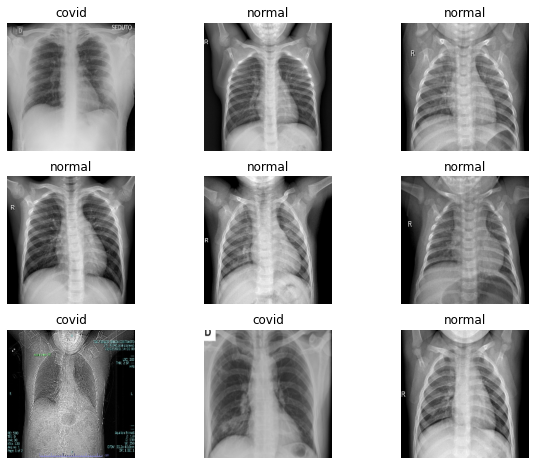

In [19]:
plt.figure(figsize=(10,8))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(image_batch[i].numpy().astype("float32"))
  idx = np.argmax(label_batch[i])
  plt.title(class_names[idx])
  plt.axis(False)


In [20]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 3)


In [21]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.05),
])

train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

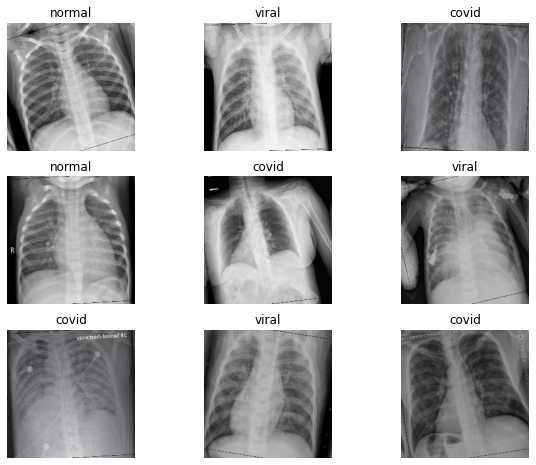

In [22]:
image_batch, label_batch = next(iter(train_ds_aug))

plt.figure(figsize=(10,8))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(image_batch[i].numpy().astype("float32"))
  idx = np.argmax(label_batch[i])
  plt.title(class_names[idx])
  plt.axis(False)

In [23]:
import numpy as np
import matplotlib.pylab as plt
from tensorflow.keras import layers
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tqdm import tqdm

print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.3.0
• Using TensorFlow Hub Version:  0.9.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
• GPU Device Found.


Use a pre-trained 50-layer ResNet from TensorHub

In [24]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/4"

In [25]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [26]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 2048)


In [74]:
feature_extractor_layer.trainable = False

In [75]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(3)
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23561152  
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 6147      
Total params: 23,567,299
Trainable params: 6,147
Non-trainable params: 23,561,152
_________________________________________________________________


In [76]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 3])

In [77]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [78]:
def summarize_diagnostics(history):
  plt.figure(figsize=(10, 10))
  # plot loss
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], color='blue', label='Training')
  plt.plot(history.history['val_loss'], color='orange', label='Test')
  plt.legend(loc='lower right')
  plt.title('Cross Entropy Loss')
  # plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(history.history['acc'], color='blue', label='Training')
  plt.plot(history.history['val_acc'], color='orange', label='Test')
  plt.legend(loc='lower right')
  plt.title('Classification Accuracy')
  plt.show()

In [79]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50, verbose=2)

Epoch 1/50
120/120 - 57s - loss: 0.7596 - acc: 0.6811 - val_loss: 0.4768 - val_acc: 0.8667
Epoch 2/50
120/120 - 56s - loss: 0.3722 - acc: 0.9119 - val_loss: 0.3191 - val_acc: 0.9111
Epoch 3/50
120/120 - 56s - loss: 0.2737 - acc: 0.9333 - val_loss: 0.2599 - val_acc: 0.9389
Epoch 4/50
120/120 - 56s - loss: 0.2287 - acc: 0.9385 - val_loss: 0.2290 - val_acc: 0.9500
Epoch 5/50
120/120 - 56s - loss: 0.2012 - acc: 0.9409 - val_loss: 0.2097 - val_acc: 0.9444
Epoch 6/50
120/120 - 56s - loss: 0.1816 - acc: 0.9450 - val_loss: 0.1963 - val_acc: 0.9500
Epoch 7/50
120/120 - 56s - loss: 0.1666 - acc: 0.9515 - val_loss: 0.1865 - val_acc: 0.9500
Epoch 8/50
120/120 - 56s - loss: 0.1545 - acc: 0.9539 - val_loss: 0.1790 - val_acc: 0.9500
Epoch 9/50
120/120 - 56s - loss: 0.1445 - acc: 0.9583 - val_loss: 0.1731 - val_acc: 0.9500
Epoch 10/50
120/120 - 56s - loss: 0.1360 - acc: 0.9609 - val_loss: 0.1684 - val_acc: 0.9500
Epoch 11/50
120/120 - 57s - loss: 0.1287 - acc: 0.9620 - val_loss: 0.1646 - val_acc: 0.95

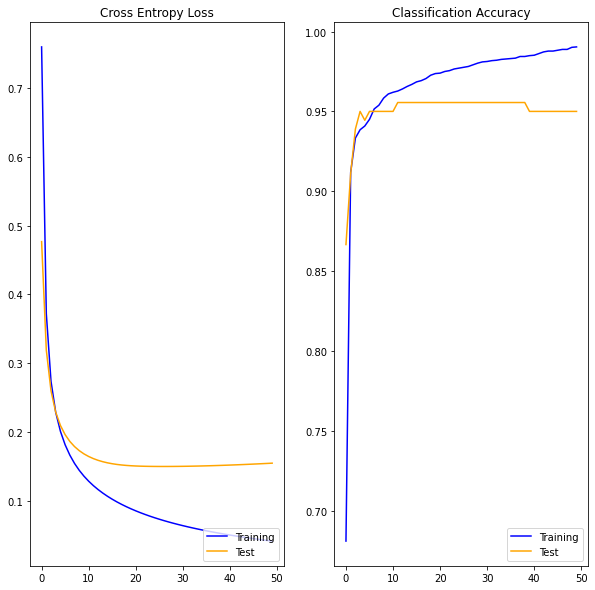

In [80]:
summarize_diagnostics(history)

In [81]:
model.evaluate(val_ds)

30/30 [==============================] - 3s 89ms/step - loss: 0.1549 - acc: 0.9500


[0.1549140065908432, 0.949999988079071]

Fine tune the model

In [82]:
feature_extractor_layer.trainable = True
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [83]:
fine_tune_epochs = 10
total_epochs =  50 + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 50/60
120/120 [==============================] - 61s 512ms/step - loss: 0.4718 - acc: 0.9213 - val_loss: 0.4267 - val_acc: 0.9167
Epoch 51/60
120/120 [==============================] - 61s 509ms/step - loss: 0.2428 - acc: 0.9987 - val_loss: 0.3910 - val_acc: 0.9611
Epoch 52/60
120/120 [==============================] - 61s 507ms/step - loss: 0.2341 - acc: 1.0000 - val_loss: 0.3994 - val_acc: 0.9556
Epoch 53/60
120/120 [==============================] - 61s 507ms/step - loss: 0.2329 - acc: 1.0000 - val_loss: 0.3984 - val_acc: 0.9556
Epoch 54/60
120/120 [==============================] - 61s 508ms/step - loss: 0.2323 - acc: 1.0000 - val_loss: 0.3824 - val_acc: 0.9611
Epoch 55/60
120/120 [==============================] - 61s 508ms/step - loss: 0.2319 - acc: 1.0000 - val_loss: 0.3709 - val_acc: 0.9611
Epoch 56/60
120/120 [==============================] - 62s 513ms/step - loss: 0.2316 - acc: 1.0000 - val_loss: 0.3750 - val_acc: 0.9556
Epoch 57/60
120/120 [===========================

In [89]:
acc = history.history['acc'] + history_fine.history['acc']
val_acc = history.history['val_acc'] + history_fine.history['val_acc']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

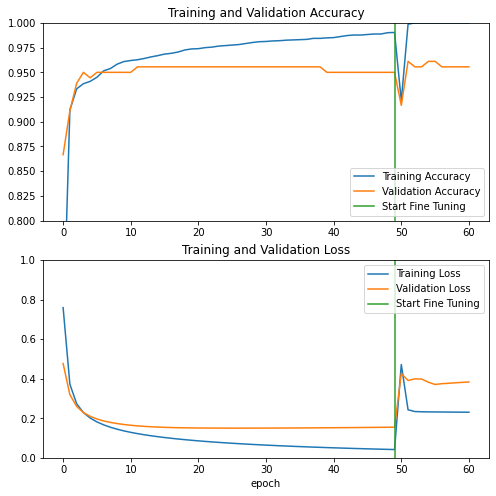

In [90]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([50-1,50-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([50-1,50-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [91]:
model.evaluate(val_ds)

30/30 [==============================] - 3s 88ms/step - loss: 0.3836 - acc: 0.9556


[0.38364818692207336, 0.9555555582046509]

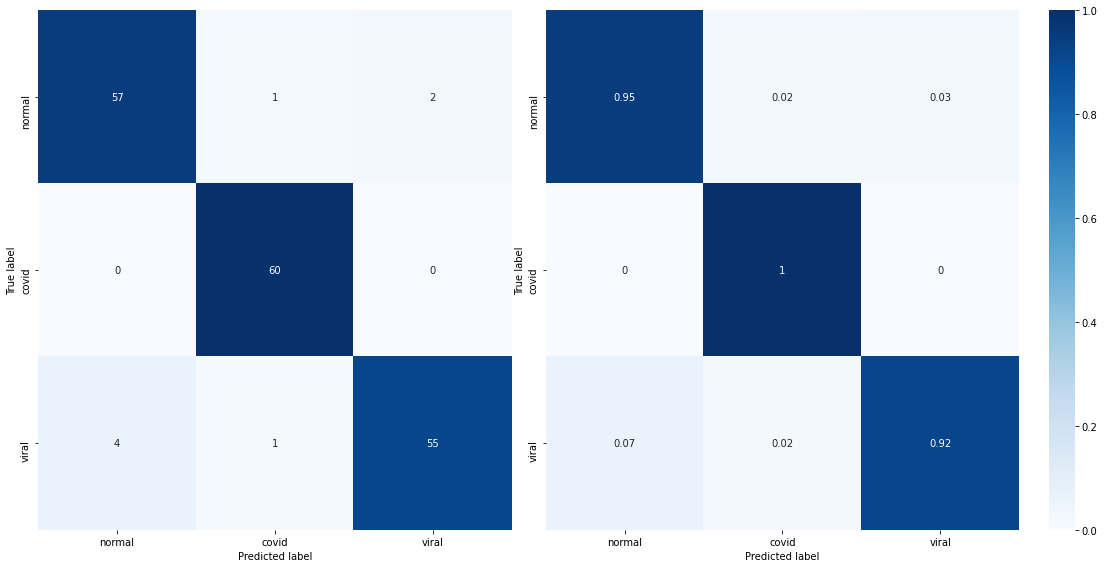

In [208]:
predicts = model.predict_classes(val_ds)
con_mat = tf.math.confusion_matrix(labels=labels, predictions=predicts).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat, index=class_names, columns=class_names)
con_mat_norm_df = pd.DataFrame(con_mat_norm, index=class_names, columns=class_names)

figure = plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.subplot(1,2,2)
sns.heatmap(con_mat_norm_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

Train 50-layer ResNet from scratch

In [56]:
base_model = tf.keras.applications.ResNet50V2(input_shape=(224,224,3), include_top=False, weights=None)

In [49]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [57]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(3)
model_scratch = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer,
])

model_scratch.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 6147      
Total params: 23,570,947
Trainable params: 23,525,507
Non-trainable params: 45,440
_________________________________________________________________


In [59]:
model_scratch.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [60]:
history_s = model_scratch.fit(train_ds, validation_data=val_ds, epochs=50, verbose=2)

Epoch 1/50
120/120 - 61s - loss: 0.3236 - acc: 0.8822 - val_loss: 9.0202 - val_acc: 0.3333
Epoch 2/50
120/120 - 60s - loss: 0.1597 - acc: 0.9414 - val_loss: 10.0717 - val_acc: 0.3333
Epoch 3/50
120/120 - 60s - loss: 0.1110 - acc: 0.9601 - val_loss: 3.7994 - val_acc: 0.4833
Epoch 4/50
120/120 - 60s - loss: 0.0726 - acc: 0.9729 - val_loss: 1.4475 - val_acc: 0.5722
Epoch 5/50
120/120 - 60s - loss: 0.0604 - acc: 0.9763 - val_loss: 0.7399 - val_acc: 0.7278
Epoch 6/50
120/120 - 60s - loss: 0.0403 - acc: 0.9870 - val_loss: 8.1976 - val_acc: 0.4278
Epoch 7/50
120/120 - 60s - loss: 0.0477 - acc: 0.9810 - val_loss: 11.1965 - val_acc: 0.3444
Epoch 8/50
120/120 - 60s - loss: 0.0411 - acc: 0.9849 - val_loss: 1.4613 - val_acc: 0.6444
Epoch 9/50
120/120 - 60s - loss: 0.0172 - acc: 0.9948 - val_loss: 2.4698 - val_acc: 0.6167
Epoch 10/50
120/120 - 60s - loss: 0.0147 - acc: 0.9948 - val_loss: 3.5407 - val_acc: 0.5000
Epoch 11/50
120/120 - 60s - loss: 0.0131 - acc: 0.9966 - val_loss: 3.2840 - val_acc: 0.

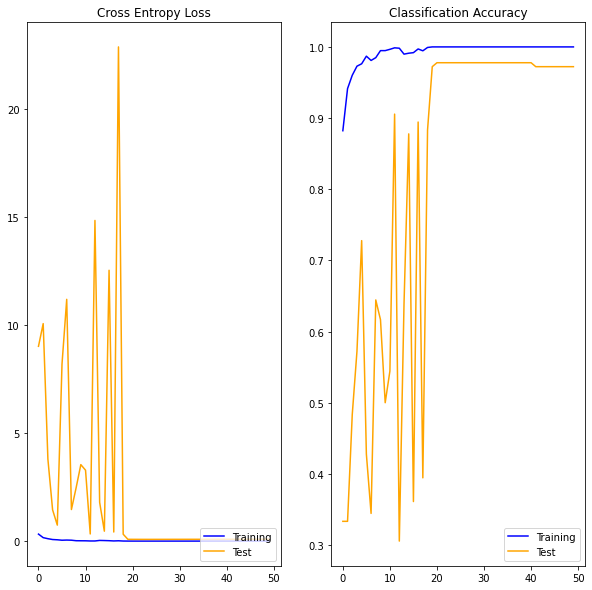

In [61]:
summarize_diagnostics(history_s)

Evaluate the pretrained ResNet 90

In [205]:
model_scratch.evaluate(val_ds)

30/30 [==============================] - 3s 89ms/step - loss: 0.0882 - acc: 0.9722


[0.08823809027671814, 0.9722222089767456]

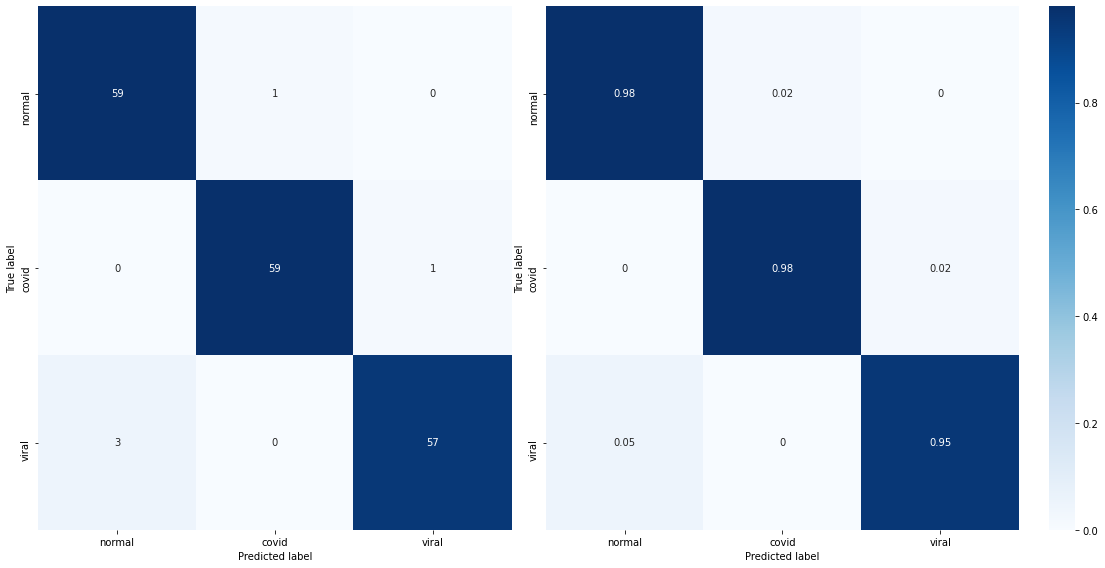

In [207]:
predicts = model_scratch.predict_classes(val_ds)
con_mat = tf.math.confusion_matrix(labels=labels, predictions=predicts).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat, index=class_names, columns=class_names)
con_mat_norm_df = pd.DataFrame(con_mat_norm, index=class_names, columns=class_names)

figure = plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.subplot(1,2,2)
sns.heatmap(con_mat_norm_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

Training on the umbalanced dataset

In [101]:
train_ds_un = train_ds1.concatenate(train_ds2).concatenate(train_ds3)
train_ds_un = train_ds_un.shuffle(len(train_ds_un), reshuffle_each_iteration=True)
print('total image in training: ', len(train_ds_un))

total image in training:  2725


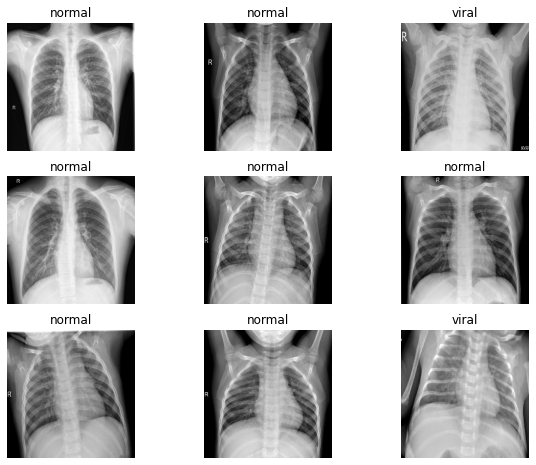

In [102]:
train_ds_un = train_ds_un.cache().prefetch(buffer_size=AUTOTUNE)
train_ds_un = train_ds_un.map(process_path, num_parallel_calls=AUTOTUNE)
train_ds_un = train_ds_un.batch(32)
image_batch, label_batch = next(iter(train_ds_un))

plt.figure(figsize=(10,8))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(image_batch[i+9].numpy().astype("float32"))
  idx = np.argmax(label_batch[i+9])
  plt.title(class_names[idx])
  plt.axis(False)

In [105]:
feature_extractor_un = hub.KerasLayer(feature_extractor_url, input_shape=(224,224,3))
feature_extractor_un.trainable = False

model_un = tf.keras.Sequential([
  feature_extractor_un,
  layers.Dense(3)
])

model_un.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 2048)              23561152  
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 6147      
Total params: 23,567,299
Trainable params: 6,147
Non-trainable params: 23,561,152
_________________________________________________________________


In [106]:
model_un.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history_un = model_un.fit(train_ds_un, validation_data=val_ds, epochs=50, verbose=2)

Epoch 1/50
86/86 - 34s - loss: 0.8581 - acc: 0.5897 - val_loss: 1.1264 - val_acc: 0.5389
Epoch 2/50
86/86 - 34s - loss: 0.4790 - acc: 0.8301 - val_loss: 0.7791 - val_acc: 0.6500
Epoch 3/50
86/86 - 33s - loss: 0.3588 - acc: 0.8782 - val_loss: 0.5955 - val_acc: 0.7167
Epoch 4/50
86/86 - 34s - loss: 0.2968 - acc: 0.9024 - val_loss: 0.4942 - val_acc: 0.7611
Epoch 5/50
86/86 - 34s - loss: 0.2595 - acc: 0.9182 - val_loss: 0.4324 - val_acc: 0.8056
Epoch 6/50
86/86 - 34s - loss: 0.2343 - acc: 0.9259 - val_loss: 0.3911 - val_acc: 0.8333
Epoch 7/50
86/86 - 33s - loss: 0.2160 - acc: 0.9328 - val_loss: 0.3615 - val_acc: 0.8389
Epoch 8/50
86/86 - 33s - loss: 0.2019 - acc: 0.9383 - val_loss: 0.3392 - val_acc: 0.8611
Epoch 9/50
86/86 - 34s - loss: 0.1905 - acc: 0.9417 - val_loss: 0.3217 - val_acc: 0.8667
Epoch 10/50
86/86 - 33s - loss: 0.1811 - acc: 0.9431 - val_loss: 0.3076 - val_acc: 0.8722
Epoch 11/50
86/86 - 33s - loss: 0.1730 - acc: 0.9468 - val_loss: 0.2959 - val_acc: 0.8833
Epoch 12/50
86/86 -

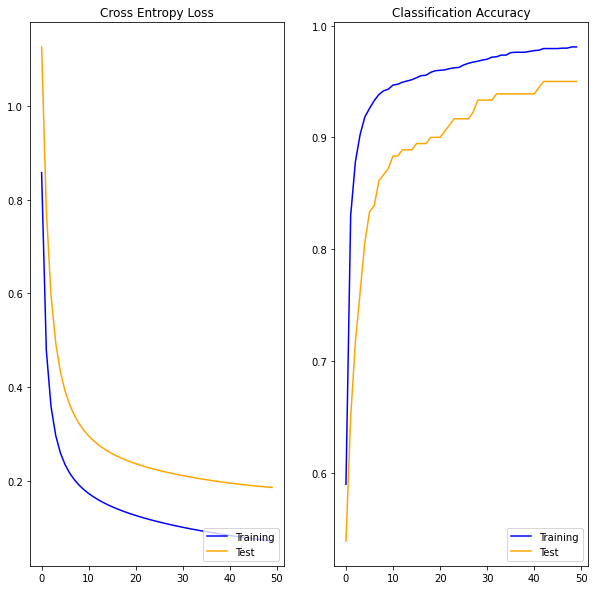

In [107]:
summarize_diagnostics(history_un)

In [108]:
model_un.evaluate(val_ds)

30/30 [==============================] - 3s 86ms/step - loss: 0.1859 - acc: 0.9500


[0.18590515851974487, 0.949999988079071]

In [110]:
feature_extractor_un.trainable = True
model_un.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [111]:
fine_tune_epochs = 10
total_epochs =  50 + fine_tune_epochs

history_fine_un = model_un.fit(train_ds_un,
                         epochs=total_epochs,
                         initial_epoch=history_un.epoch[-1],
                         validation_data=val_ds, verbose=2)

Epoch 50/60
86/86 - 37s - loss: 0.7020 - acc: 0.8352 - val_loss: 0.7736 - val_acc: 0.8333
Epoch 51/60
86/86 - 37s - loss: 0.2650 - acc: 0.9949 - val_loss: 0.4302 - val_acc: 0.9167
Epoch 52/60
86/86 - 36s - loss: 0.2392 - acc: 1.0000 - val_loss: 0.4026 - val_acc: 0.9333
Epoch 53/60
86/86 - 37s - loss: 0.2354 - acc: 1.0000 - val_loss: 0.4027 - val_acc: 0.9222
Epoch 54/60
86/86 - 36s - loss: 0.2340 - acc: 1.0000 - val_loss: 0.3975 - val_acc: 0.9389
Epoch 55/60
86/86 - 37s - loss: 0.2332 - acc: 1.0000 - val_loss: 0.3920 - val_acc: 0.9556
Epoch 56/60
86/86 - 36s - loss: 0.2327 - acc: 1.0000 - val_loss: 0.3868 - val_acc: 0.9500
Epoch 57/60
86/86 - 37s - loss: 0.2323 - acc: 1.0000 - val_loss: 0.3877 - val_acc: 0.9500
Epoch 58/60
86/86 - 36s - loss: 0.2320 - acc: 1.0000 - val_loss: 0.3933 - val_acc: 0.9500
Epoch 59/60
86/86 - 37s - loss: 0.2318 - acc: 1.0000 - val_loss: 0.3984 - val_acc: 0.9556
Epoch 60/60
86/86 - 37s - loss: 0.2315 - acc: 1.0000 - val_loss: 0.4014 - val_acc: 0.9556


In [112]:
acc = history_un.history['acc'] + history_fine_un.history['acc']
val_acc = history_un.history['val_acc'] + history_fine_un.history['val_acc']

loss = history_un.history['loss'] + history_fine_un.history['loss']
val_loss = history_un.history['val_loss'] + history_fine_un.history['val_loss']

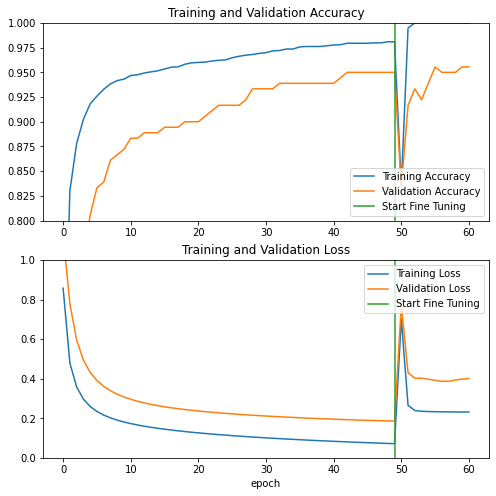

In [113]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([50-1,50-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([50-1,50-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [151]:
predicts = model_un.predict_classes(val_ds)

In [193]:
labels = []
for imgs, label in val_ds.as_numpy_iterator():
  label_batch = (np.argmax(label,axis=-1))
  for item in label_batch:
    labels.append(item)

In [194]:
labels = np.array(labels)
labels.shape

(180,)

In [197]:
con_mat = tf.math.confusion_matrix(labels=labels, predictions=predicts).numpy()

In [198]:
# class_names = ['normal', 'covid', 'viral']
con_mat

array([[58,  1,  1],
       [ 0, 60,  0],
       [ 6,  0, 54]], dtype=int32)

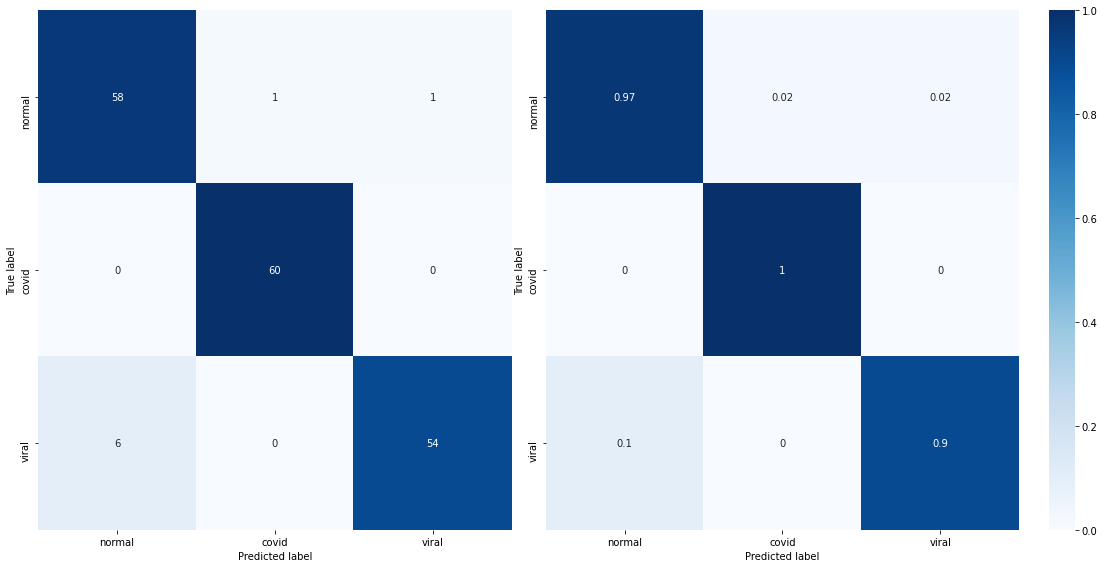

In [204]:
import pandas as pd
import seaborn as sns

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat, index=class_names, columns=class_names)
con_mat_norm_df = pd.DataFrame(con_mat_norm, index=class_names, columns=class_names)

figure = plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.subplot(1,2,2)
sns.heatmap(con_mat_norm_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()